In [47]:
from datasets import load_dataset
from transformers import AutoTokenizer

In [48]:
import torch
from transformers import BertForTokenClassification, BertTokenizer,  BertForMaskedLM, Trainer, TrainingArguments
from datasets import load_dataset
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import os
from transformers import BertTokenizerFast
import evaluate
import pandas as pd
import random
from datasets import DatasetDict
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from datasets import load_dataset

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [50]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [51]:
dataset = load_dataset("jnlpba", trust_remote_code = True)



In [52]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 18546
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3856
    })
})

In [53]:
# Define a sampling function
def sample_dataset(data, ratio):
    sample_size = int(len(data) * ratio)
    return data.select(random.sample(range(len(data)), sample_size))

# Set the ratio
ratio = 0.05

# Sample each subset
train_sampled = sample_dataset(dataset['train'], ratio)
validation_sampled = sample_dataset(dataset['validation'], ratio)

# Check the sizes
print(f"Sampled train size: {len(train_sampled)}")
print(f"Sampled validation size: {len(validation_sampled)}")


dataset = DatasetDict({
    "train": train_sampled,
    "validation": validation_sampled
})


Sampled train size: 927
Sampled validation size: 192


In [54]:
dataset['train'][0]['tokens']

['Because',
 'the',
 '-180',
 'site',
 'is',
 'not',
 'required',
 'for',
 'trans-activation',
 ',',
 'it',
 'was',
 'possible',
 'to',
 'confirm',
 'by',
 'mutation',
 'in',
 'the',
 'normal',
 'mouse',
 'IL-2',
 'enhancer',
 'that',
 'this',
 'site',
 'is',
 'absolutely',
 'essential',
 'for',
 'anergy',
 'induction',
 '.']

In [55]:
dataset['train'][0]['ner_tags']

[0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [56]:
dataset['train'][0]['id']

'3649'

In [57]:
label_list = dataset["train"].features[f"ner_tags"].feature.names
num_labels = len(label_list)
label_list



['O',
 'B-DNA',
 'I-DNA',
 'B-RNA',
 'I-RNA',
 'B-cell_line',
 'I-cell_line',
 'B-cell_type',
 'I-cell_type',
 'B-protein',
 'I-protein']

In [58]:
sample_data = dataset["train"].select(range(10)) 

df = pd.DataFrame({
    "tokens": [" ".join(example["tokens"]) for example in sample_data],
    "ner_tags": [example["ner_tags"] for example in sample_data]
})

df

,tokens,ner_tags
0,Because the -180 site is not required for tran...,"[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Mutations in this DNA-binding site abolished b...,"[0, 0, 0, 1, 2, 0, 0, 0, 0, 9, 10, 0, 0, 0, 0,..."
2,"This may explain , at least in part , the incr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Somatic hypermutation is the most critical mec...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0]"
4,"Moreover , anti- STAT3 antibodies specifically...","[0, 0, 0, 9, 10, 0, 0, 0, 0, 0, 9, 10, 0, 0, 0..."
5,IL-4 and IL-10 inhibit the cytokine production...,"[9, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 7, 0]"
6,Although it has been postulated that pituitary...,"[0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 7, 8, 8, 0, 0, ..."
7,This conclusion was based upon several indepen...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,To understand the mechanism by which PRL regul...,"[0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, ..."
9,Ex vivo activation of tumor-draining lymph nod...,"[0, 0, 0, 0, 7, 8, 8, 8, 8, 0, 0, 0, 9, 10, 10..."


B- indicates the beginning of an entity.
I- indicates a token is contained inside the same entity (for example, the State token is a part of an entity like Empire State Building).
0 indicates the token doesn’t correspond to any entity.

In [59]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [60]:

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding='max_length',
        max_length=128
    )
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs





In [61]:

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

In [62]:
tokenized_datasets['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 927
})

In [63]:
tokenized_datasets['train'][0]

{'id': '3649',
 'tokens': ['Because',
  'the',
  '-180',
  'site',
  'is',
  'not',
  'required',
  'for',
  'trans-activation',
  ',',
  'it',
  'was',
  'possible',
  'to',
  'confirm',
  'by',
  'mutation',
  'in',
  'the',
  'normal',
  'mouse',
  'IL-2',
  'enhancer',
  'that',
  'this',
  'site',
  'is',
  'absolutely',
  'essential',
  'for',
  'anergy',
  'induction',
  '.'],
 'ner_tags': [0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'input_ids': [101,
  2279,
  1103,
  118,
  7967,
  1751,
  1110,
  1136,
  2320,
  1111,
  14715,
  118,
  14915,
  117,
  1122,
  1108,
  1936,
  1106,
  12434,
  1118,
  17895,
  1107,
  1103,
  2999,
  10322,
  15393,
  118,
  123,
  11778,
  1197,
  1115,
  1142,
  1751,
  1110,
  7284,
  6818,
  1111,
  1126,
  1200,
  4873,
  18293,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [64]:

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=num_labels)


metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Usunięcie indeksów ignorowanych (specjalne tokeny)
    true_predictions = [
        [p for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [l for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Spłaszczanie list
    true_predictions_flat = [int(item) for sublist in true_predictions for item in sublist]
    true_labels_flat = [int(item) for sublist in true_labels for item in sublist]

    # Zbieranie błędnych przykładów
    incorrect_examples = []
    for idx, (pred, label) in enumerate(zip(true_predictions, true_labels)):
        if pred != label:
            tokens = tokenized_datasets["validation"]["tokens"][idx]  # Oryginalne tokeny dla przykładu
            incorrect_examples.append({
                "tokens": tokens,
                "true_labels": label,
                "predicted_labels": pred
            })

    # Zapis błędnych przykładów do CSV
    if incorrect_examples:
        df_incorrect = pd.DataFrame(incorrect_examples)
        df_incorrect.to_csv("incorrect_predictions_trained.csv", index=False)

    # Obliczanie dokładności i F1
    accuracy = metric.compute(predictions=true_predictions_flat, references=true_labels_flat)
    f1 = f1_metric.compute(predictions=true_predictions_flat, references=true_labels_flat, average="weighted")["f1"]

    # Obliczenie macierzy pomyłek
    labels_list = list(set(true_labels_flat))  # Lista unikalnych etykiet NER
    cm = confusion_matrix(true_labels_flat, true_predictions_flat, labels=labels_list)
    
    # Wyświetlenie macierzy pomyłek
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    disp.ax_.set_title("Confusion Matrix for NER Labels")
    
    return {"accuracy": accuracy, "f1": f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.1,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)




Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

/tmp/ipykernel_6430/575272815.py:71: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [65]:
# peft_config = LoraConfig(
#     task_type=TaskType.TOKEN_CLS,  r=64, lora_alpha=1
# )

In [66]:
# model = get_peft_model(model, p# "trainable params: 1855499 || all params: 355894283 || trainable%: 0.5213624069370061"

In [67]:
# Evaluate the model
# trainer.evaluate()

In [68]:
# trainer.train()
# trainer.save_model("./saved_model_bert_for_token")

100%|██████████| 24/24 [00:01<00:00, 17.84it/s]


{'eval_loss': 2.4702162742614746,
 'eval_model_preparation_time': 0.0016,
 'eval_accuracy': {'accuracy': 0.06849585471772601},
 'eval_f1': 0.09719990078146179,
 'eval_runtime': 1.3864,
 'eval_samples_per_second': 138.491,
 'eval_steps_per_second': 17.311}

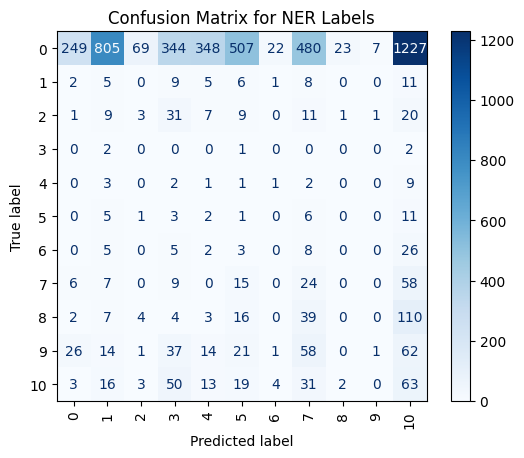

In [69]:
trainer.evaluate()

# Wizualizacje na wytrenowanym modelu

In [70]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

model_path = "./saved_model_bert_for_token"

model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

/tmp/ipykernel_6430/3608341357.py:12: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

100%|██████████| 24/24 [00:01<00:00, 18.99it/s]


{'eval_loss': 0.5167544484138489,
 'eval_model_preparation_time': 0.0018,
 'eval_accuracy': {'accuracy': 0.9137386498223451},
 'eval_f1': 0.916294490994645,
 'eval_runtime': 1.2964,
 'eval_samples_per_second': 148.101,
 'eval_steps_per_second': 18.513}

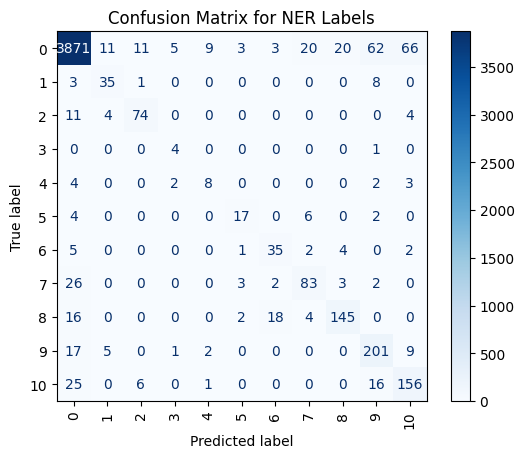

In [71]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.1,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


trainer.evaluate()

In [78]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np



test_dataset = tokenized_datasets["validation"].select(range(15))
print(test_dataset[0])


def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    
    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"],is_split_into_words=True,return_tensors="pt", truncation=True, padding='max_length', max_length=128
            ).to(device)
            outputs = model(**inputs, output_hidden_states=True)
       
            token_embeddings = outputs.hidden_states[-1].squeeze(0) 
            embeddings.append(token_embeddings.cpu().numpy())
            labels.extend(example["ner_tags"])
            tokens.extend(example["tokens"])


    flat_embeddings = np.vstack([embedding[:len(label)] for embedding, label in zip(embeddings, dataset["ner_tags"])])
    flat_labels = [label for sublist in dataset["ner_tags"] for label in sublist]
    flat_tokens = [token for sublist in dataset["tokens"] for token in sublist]
    return flat_embeddings, flat_labels, flat_tokens

embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)


reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Test Examples",
    labels={"color": "NER Label"}
)
fig.show()


{'id': '307', 'tokens': ['The', 'percentages', 'of', 'the', 'T/NK-cell', 'subsets', 'in', 'the', 'PB', 'were', 'not', 'significantly', 'different', 'among', 'these', 'groups', '.'], 'ner_tags': [0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [101, 1109, 6556, 1116, 1104, 1103, 157, 120, 151, 2428, 118, 2765, 18005, 1116, 1107, 1103, 153, 2064, 1127, 1136, 5409, 1472, 1621, 1292, 2114, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [79]:
# Dodajmy identyfikatory przykładów do DataFrame
example_ids = []
for idx, example in enumerate(test_dataset):
    example_ids.extend([idx] * len(example["tokens"]))

# Aktualizujemy DataFrame o identyfikatory przykładów
df["example_id"] = example_ids

# Tworzymy nowy wykres
fig2 = px.scatter(
    df, x="x", y="y", color="example_id", hover_data=["token"],
    title="2D Vector Space of Test Examples (Grouped by Example)",
    labels={"color": "Example ID"}
)
fig2.show()


# Wizauliacja poprawnych przykładów

In [80]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np
from datasets import load_dataset

test_dataset = dataset["validation"].select(range(100))  

# Funkcja do uzyskania embeddingów i przewidywań
def get_predictions_and_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    true_labels = []
    pred_labels = []
    tokens = []
    correct_examples = []

    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

            # Pobieramy embeddingi
            token_embeddings = outputs.hidden_states[-1].squeeze(0).cpu().numpy()
            true_label = example["ner_tags"]
            tokens.extend(example["tokens"])

            # Dopasowujemy długość predykcji do prawdziwych etykiet
            predictions = predictions[:len(true_label)]

            if list(predictions) == true_label:
                embeddings.append(token_embeddings[:len(true_label)])
                true_labels.extend(true_label)
                pred_labels.extend(predictions)
                correct_examples.extend(example["tokens"])

    # Spłaszczamy embeddingi
    flat_embeddings = np.vstack([emb for emb in embeddings])
    flat_labels = true_labels
    flat_tokens = [token for sublist in correct_examples for token in sublist]

    return flat_embeddings, flat_labels, flat_tokens

# Pobieramy embeddingi i poprawnie sklasyfikowane przykłady
embeddings, labels, tokens = get_predictions_and_embeddings(test_dataset, model, tokenizer)

# Sprawdzamy najmniejszą długość
min_length = min(len(reduced_embeddings), len(labels), len(tokens))

# Przycinamy listy do tej długości
reduced_embeddings = reduced_embeddings[:min_length]
labels = labels[:min_length]
tokens = tokens[:min_length]

# Tworzymy DataFrame do wizualizacji
df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

# Wizualizacja za pomocą Plotly
fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Correctly Classified Examples",
    labels={"color": "NER Label"}
)
fig.show()


In [81]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np



test_dataset = tokenized_datasets["train"]
print(test_dataset[0])

def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    
    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu()

            token_embeddings = outputs.hidden_states[-1].squeeze(0)
            true_label = example["ner_tags"]
            predictions = predictions[:len(true_label)]

            # Only append correctly classified examples
            if list(predictions) == true_label:
                embeddings.append(token_embeddings[:len(true_label)].cpu().numpy())
                labels.extend(true_label)
                tokens.extend(example["tokens"][:len(true_label)])

    # Flatten the embeddings and ensure lengths match
    flat_embeddings = np.vstack(embeddings)
    flat_labels = labels
    flat_tokens = tokens

    print(f"Lengths - embeddings: {len(flat_embeddings)}, labels: {len(flat_labels)}, tokens: {len(flat_tokens)}")

    return flat_embeddings, flat_labels, flat_tokens



embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)


reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Test Examples",
    labels={"color": "NER Label"}
)
fig.show()


{'id': '3649', 'tokens': ['Because', 'the', '-180', 'site', 'is', 'not', 'required', 'for', 'trans-activation', ',', 'it', 'was', 'possible', 'to', 'confirm', 'by', 'mutation', 'in', 'the', 'normal', 'mouse', 'IL-2', 'enhancer', 'that', 'this', 'site', 'is', 'absolutely', 'essential', 'for', 'anergy', 'induction', '.'], 'ner_tags': [0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'input_ids': [101, 2279, 1103, 118, 7967, 1751, 1110, 1136, 2320, 1111, 14715, 118, 14915, 117, 1122, 1108, 1936, 1106, 12434, 1118, 17895, 1107, 1103, 2999, 10322, 15393, 118, 123, 11778, 1197, 1115, 1142, 1751, 1110, 7284, 6818, 1111, 1126, 1200, 4873, 18293, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 

# Poprawe z wyłączeniem 0

In [82]:
def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    accuracy_threshold = 0.6  

    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu()

            # Pobieramy embeddingi i prawdziwe etykiety
            token_embeddings = outputs.hidden_states[-1].squeeze(0)
            true_labels = example["ner_tags"]
            tokens_list = example["tokens"]

        
            predictions = predictions[:len(true_labels)]

            # Filtrowanie etykiet `0`
            non_zero_indices = [i for i, label in enumerate(true_labels) if label != 0]
            filtered_predictions = [predictions[i] for i in non_zero_indices]
            filtered_true_labels = [true_labels[i] for i in non_zero_indices]
            filtered_tokens = [tokens_list[i] for i in non_zero_indices]
            filtered_embeddings = token_embeddings[non_zero_indices].cpu().numpy()


            if len(filtered_true_labels) > 0: 
                correct_predictions = sum(
                    [1 for pred, true in zip(filtered_predictions, filtered_true_labels) if pred == true]
                )
                accuracy = correct_predictions / len(filtered_true_labels)

    
                if accuracy >= accuracy_threshold:
                    embeddings.append(filtered_embeddings)
                    labels.extend(filtered_true_labels)
                    tokens.extend(filtered_tokens)

    # Spłaszczamy listy
    flat_embeddings = np.vstack(embeddings)
    flat_labels = labels
    flat_tokens = tokens

    print(f"Lengths - embeddings: {len(flat_embeddings)}, labels: {len(flat_labels)}, tokens: {len(flat_tokens)}")

    return flat_embeddings, flat_labels, flat_tokens


In [83]:
embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)
reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Test Examples",
    labels={"color": "NER Label"}
)
fig.show()

Lengths - embeddings: 117, labels: 117, tokens: 117
